In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.storms import Extract_Circle, GetCategoryChangeProbs
from teslakit.plotting.storms import Plot_Category_Change



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# load data and set parameters

xds_Nakajo = db.Load_TCs_Nakajo()  # Nakajo simulations

# wave point longitude and latitude
pnt_lon = 167.5
pnt_lat = 9.75

# radius for TCs selection (º)
r1 = 14
r2 = 4



## Synthetic TCs - Category Change Probabilities

In [4]:
# --------------------------------------
# Select Nakajo TCs inside circle

# dictionary with needed variable names
d_vns = {
    'longitude':'ylon_TC',
    'latitude':'ylat_TC',
    'time': 'yts',
    'pressure':'yCPRES',
}

# Extract TCs inside R=14 and positions
_, xds_in_r1 = Extract_Circle(xds_Nakajo, pnt_lon, pnt_lat, r1, d_vns)

# Extract TCs inside R=4 and positions
_, xds_in_r2 = Extract_Circle(xds_Nakajo, pnt_lon, pnt_lat, r2, d_vns)

print(xds_in_r1)
print()
print(xds_in_r2)


<xarray.Dataset>
Dimensions:        (storm: 61125)
Coordinates:
  * storm          (storm) int64 5 8 14 50 52 ... 999974 999982 999986 999990
Data variables:
    pressure_min   (storm) float64 983.2 932.8 960.5 978.9 ... 968.4 973.3 992.4
    pressure_mean  (storm) float64 988.5 970.4 990.6 990.9 ... 989.3 995.5 998.9
    velocity_mean  (storm) float64 175.1 11.85 22.53 53.32 ... 11.99 19.86 9.651
    gamma          (storm) float64 114.2 166.6 73.03 60.19 ... 138.9 116.8 117.4
    delta          (storm) float64 113.0 225.8 24.94 25.63 ... 150.2 131.7 110.1
    category       (storm) int64 1 4 3 2 1 0 0 0 1 5 1 ... 0 4 1 2 1 1 4 0 2 2 1
    dmin_date      (storm) float64 45.4 63.0 42.0 264.0 ... 6.0 0.0 24.0 0.0
    last_date      (storm) float64 54.4 288.0 259.5 400.5 ... 150.0 259.5 177.0
    index_in       (storm) int64 61 0 1 90 0 0 4 6 0 31 ... 7 0 0 0 0 0 0 0 0 0
    index_out      (storm) int64 86 39 33 110 19 14 31 ... 27 16 26 9 38 30 18
Attributes:
    point_lon:  167.5
    po

In [5]:
# --------------------------------------
# Calculate Syntethic TCs category change probabilities

xds_categ_cp = GetCategoryChangeProbs(xds_in_r1, xds_in_r2)
print(xds_categ_cp)

db.Save_TCs_probs_synth(xds_categ_cp)


<xarray.Dataset>
Dimensions:                  (category: 6)
Coordinates:
  * category                 (category) int64 0 1 2 3 4 5
Data variables:
    category_change_count    (category, category) int64 1739 1281 263 ... 0 281
    category_change_sum      (category) int64 19969 18494 3709 4183 1857 969
    category_change_probs    (category, category) float64 0.08011 ... 0.1148
    category_nochange_probs  (category) float64 0.9199 0.8809 ... 0.4367 0.396
    category_change_cumsum   (category, category) float64 0.08011 ... 0.604


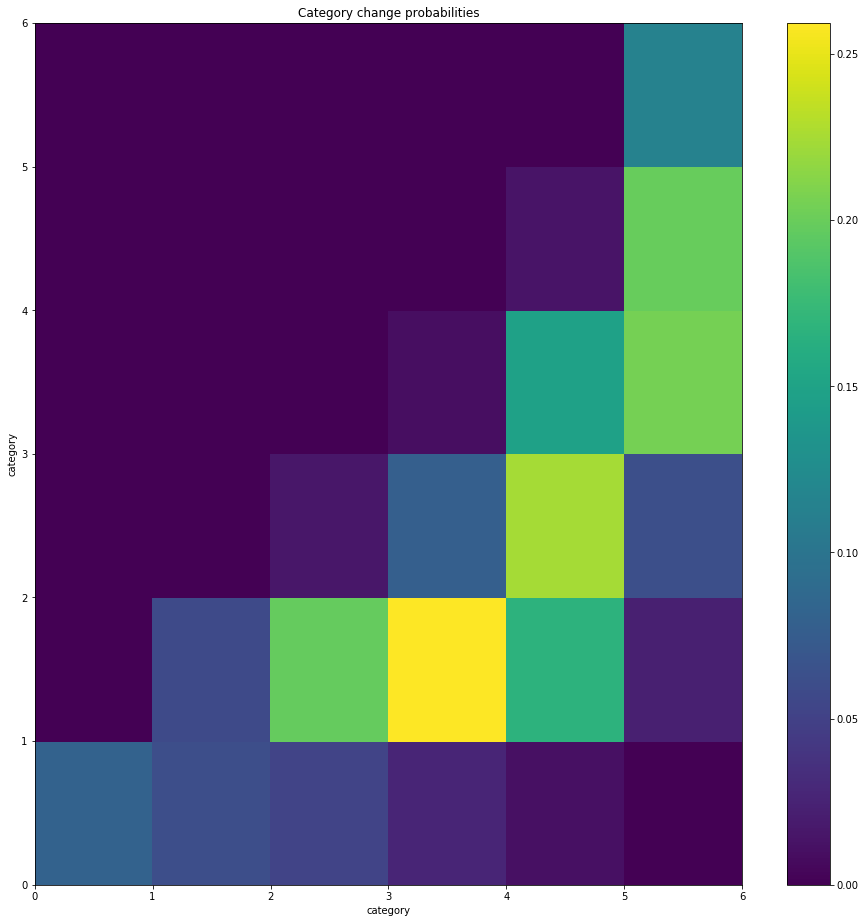

In [6]:
# plot category change probabilities

Plot_Category_Change(xds_categ_cp)
